In [814]:
#En este notebook es donde vamos a proceder a manipular la df que tenemos, de momento vamos a ir importando.

In [815]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [816]:
df = pd.read_csv("../Raw/steam.csv")
df = df.dropna()
#Nota: Dropna solo ha quitado 15 filas, nada de lo que preocuparse.

In [817]:
#tenemos varias columnas que no nos aportan nada interesante, las quitamos.
df = df.drop(["appid", "owners"], axis=1)

In [818]:
#se ve bien, vamos a empezar ese feature engineering.
#Nuestro target sera la columna de precio, por el momento, la voy a mantener, ya que si hago modficaciones a las filas, quiero al menos que se haga ahi tambien.

In [819]:
#voy a hacer varias DF, primero separare por categorias.
df["porcentage_positivas"] = round(df["positive_ratings"] / (df["positive_ratings"] + df["negative_ratings"]) *100, 2)
df=df[df["price"] < 50]
df=df[df["price"] != 0]
cat_df = df.copy()

In [820]:
len(cat_df["developer"].value_counts())

15350

In [821]:
#por el momento, quitare todo lo que no este relacionado con las categorias, tambien mantendremos las plataformas.
cat_df = cat_df.drop(["release_date", "positive_ratings","negative_ratings","developer","price"], axis=1)

In [822]:
label_encoder = LabelEncoder()
cat_df["publisher"] = label_encoder.fit_transform(cat_df["publisher"])


In [823]:
cat_df["platforms"].value_counts()

platforms
windows              16552
windows;mac;linux     4276
windows;mac           3074
windows;linux          562
mac                      2
mac;linux                1
Name: count, dtype: int64

In [824]:
#vamos a dividirlos por los sistemas operativos que usan.

op_sys = cat_df['platforms'].str.split(';',expand=True)
#ahora les cambio el nombre, para tenerlas bien organizadas.
op_sys.columns = ["windows","mac","linux"]
#vamos a tener Nones, que se tratan como Nan
op_sys.fillna(0, inplace=True)

In [825]:
def cambiar_texto(df, columna, antes, despues):
    if type(columna) == str or type(antes) == str or type(despues) == str:
        df[columna] = df[columna].str.replace(antes, despues)
        return df
    else:
        print("por favor, pasa los datos correctamente.")

In [826]:
print(op_sys["windows"].value_counts())
print(op_sys["mac"].value_counts())
print(op_sys["linux"].value_counts())

windows
windows    24464
mac            3
Name: count, dtype: int64
mac
0        16554
mac       7350
linux      563
Name: count, dtype: int64
linux
0        20191
linux     4276
Name: count, dtype: int64


In [827]:
#op_sys = cambiar_texto(op_sys, "windows", "windows","1")
op_sys["windows"].value_counts()

#parece que se ha equivocado con los valores, vamos a arreglarlo.
#Linux parece no tener malos valores, como estaba mas a la derecha, vamos con mac directamente y metemos los valores que le falten a Linux
#Para no comerme posibles valores, primero haremos de mac a linux, y luego de windows al resto.

op_sys.loc[op_sys['mac'] == 'linux', 'linux'] = "linux"
op_sys.loc[op_sys['mac'] == 'linux'] = 0

#ahora windows

op_sys.loc[op_sys['windows'] == 'linux', 'linux'] = "linux"
op_sys.loc[op_sys['windows'] == 'mac', 'mac'] = "mac"
op_sys.loc[op_sys['windows'] != 'windows'] = 0


In [828]:
print(op_sys["windows"].value_counts())
print(op_sys["mac"].value_counts())
print(op_sys["linux"].value_counts())

windows
windows    23902
0            565
Name: count, dtype: int64
mac
0      17117
mac     7350
Name: count, dtype: int64
linux
0        20191
linux     4276
Name: count, dtype: int64


In [829]:
#ahora podemos cambiar el texto.
op_sys = cambiar_texto(op_sys, "windows", "windows","1")
op_sys = cambiar_texto(op_sys, "linux", "linux","1")
op_sys = cambiar_texto(op_sys, "mac", "mac","1")

In [830]:
#vamos a tener Nones, que se tratan como Nan
op_sys.fillna(0, inplace=True)

In [831]:
print(op_sys["windows"].value_counts())
print(op_sys["mac"].value_counts())
print(op_sys["linux"].value_counts())

windows
1    23902
0      565
Name: count, dtype: int64
mac
0    17117
1     7350
Name: count, dtype: int64
linux
0    20191
1     4276
Name: count, dtype: int64


In [832]:
op_sys
#esta perfecta.

,windows,mac,linux
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
27070,1,0,0
27071,1,0,0
27072,1,0,0
27073,1,1,0


In [833]:
#Metemos las 3 nuevas que he creado.

cat_df = pd.concat([cat_df, op_sys], axis=1)

cat_df

,name,english,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,porcentage_positivas,windows,mac,linux
0,Counter-Strike,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,17612,317,97.39,1,1,1
1,Team Fortress Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,83.98,1,1,1
2,Day of Defeat,1,11199,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,187,34,89.56,1,1,1
3,Deathmatch Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,258,184,82.66,1,1,1
4,Half-Life: Opposing Force,1,11199,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,624,415,94.80,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,1,9079,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,0,0,100.00,1,0,0
27071,Cyber Gun,1,1239,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,0,0,88.89,1,0,0
27072,Super Star Blast,1,3363,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,0,0.00,1,0,0
27073,New Yankee 7: Deer Hunters,1,503,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,0,0,100.00,1,1,0


In [834]:
#vamos a dividirlos de forma basica, si es multijugador, single player, tiene Anti-cheat...
#mejor, creo una funcion para esto.
def filtrar(df,columna_objetivo, texto, columna_nueva):
    df[columna_nueva] = df[columna_objetivo].apply(lambda x: 1 if texto in x else 0)
    return df

cat_df = filtrar(cat_df, 'categories', 'Multi-player', 'Multi-player')
cat_df = filtrar(cat_df, 'categories', 'Online', 'Online')
cat_df = filtrar(cat_df, 'categories', 'Single-player', 'Single-player')
cat_df = filtrar(cat_df, 'categories', 'Anti-Cheat', 'Anti-Cheat')

In [835]:
#para genre, vamos a ponerles solo el primero que tengan, luego lo convertiremos con label encoder

def primero(df, columna):

    generos = df[columna].str.split(';',expand=True)
    df[columna] = generos[0]
    return df

In [836]:
cat_df = primero(cat_df, "genres")

In [837]:
cat_df["genres"].value_counts()
#me gusta, tiene de todo y eso esta bien, por el momento.
#para la realizacion de este trabajo, se cogeran las superiores a 300

genres
Action                   10289
Adventure                 4810
Casual                    3917
Indie                     2514
Violent                    652
Simulation                 580
Strategy                   504
RPG                        393
Sexual Content             222
Racing                     187
Nudity                     103
Gore                        76
Sports                      74
Animation & Modeling        48
Utilities                   32
Design & Illustration       19
Audio Production            14
Massively Multiplayer       11
Education                    8
Early Access                 8
Free to Play                 2
Web Publishing               1
Photo Editing                1
Accounting                   1
Video Production             1
Name: count, dtype: int64

In [838]:
tags = cat_df["steamspy_tags"].str.split(';',expand=True)
tags[2].value_counts()
#no puedo usar esto, tiene demasiadas filas, si hiciese un get dummies acabaria con 300 columnas y eso no ayudaria.
#segun el ejercicio del cancer, no pasa nada si tengo 30 columnas...
#vamos a hacer una prueba, vamos a hacer una nueva DF y cogemos solo los mas comunes

2
Indie         3852
Casual        2430
Adventure     1740
Action        1291
Simulation    1099
              ... 
Bowling          1
America          1
Skating          1
Tennis           1
Logic            1
Name: count, Length: 320, dtype: int64

In [839]:
testeo = cat_df.copy()
testeo = filtrar(testeo, 'steamspy_tags', 'Indie', 'Indie')
testeo = filtrar(testeo, 'steamspy_tags', 'Action', 'Action')
testeo = filtrar(testeo, 'steamspy_tags', 'Adventure', 'Adventure')
testeo = filtrar(testeo, 'steamspy_tags', 'Casual', 'Casual')
testeo = filtrar(testeo, 'steamspy_tags', 'Strategy', 'Strategy')
testeo = filtrar(testeo, 'steamspy_tags', 'Simulation', 'Simulation')

In [840]:
cat_df

,name,english,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,porcentage_positivas,windows,mac,linux,Multi-player,Online,Single-player,Anti-Cheat
0,Counter-Strike,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,17612,317,97.39,1,1,1,1,1,0,1
1,Team Fortress Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,83.98,1,1,1,1,1,0,1
2,Day of Defeat,1,11199,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,187,34,89.56,1,1,1,1,0,0,1
3,Deathmatch Classic,1,11199,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,258,184,82.66,1,1,1,1,1,0,1
4,Half-Life: Opposing Force,1,11199,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,624,415,94.80,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,1,9079,windows,0,Single-player;Steam Achievements,Adventure,Adventure;Indie;Casual,7,0,0,100.00,1,0,0,0,0,1,0
27071,Cyber Gun,1,1239,windows,0,Single-player,Action,Action;Indie;Adventure,0,0,0,88.89,1,0,0,0,0,1,0
27072,Super Star Blast,1,3363,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action,Action;Indie;Casual,24,0,0,0.00,1,0,0,1,0,1,0
27073,New Yankee 7: Deer Hunters,1,503,windows;mac,0,Single-player;Steam Cloud,Adventure,Indie;Casual;Adventure,0,0,0,100.00,1,1,0,0,0,1,0


In [841]:
test = pd.concat([testeo, df["price"]], axis=1)
test = test.drop(["name","english", "platforms", "categories", "genres", "steamspy_tags"],axis=1)

In [842]:
test

,publisher,required_age,achievements,average_playtime,median_playtime,porcentage_positivas,windows,mac,linux,Multi-player,Online,Single-player,Anti-Cheat,Indie,Action,Adventure,Casual,Strategy,Simulation,price
0,11199,0,0,17612,317,97.39,1,1,1,1,1,0,1,0,1,0,0,0,0,7.19
1,11199,0,0,277,62,83.98,1,1,1,1,1,0,1,0,1,0,0,0,0,3.99
2,11199,0,0,187,34,89.56,1,1,1,1,0,0,1,0,0,0,0,0,0,3.99
3,11199,0,0,258,184,82.66,1,1,1,1,1,0,1,0,1,0,0,0,0,3.99
4,11199,0,0,624,415,94.80,1,1,1,1,0,1,1,0,1,0,0,0,0,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,9079,0,7,0,0,100.00,1,0,0,0,0,1,0,1,0,1,1,0,0,2.09
27071,1239,0,0,0,0,88.89,1,0,0,0,0,1,0,1,1,1,0,0,0,1.69
27072,3363,0,24,0,0,0.00,1,0,0,1,0,1,0,1,1,0,1,0,0,3.99
27073,503,0,0,0,0,100.00,1,1,0,0,0,1,0,1,0,1,1,0,0,5.19


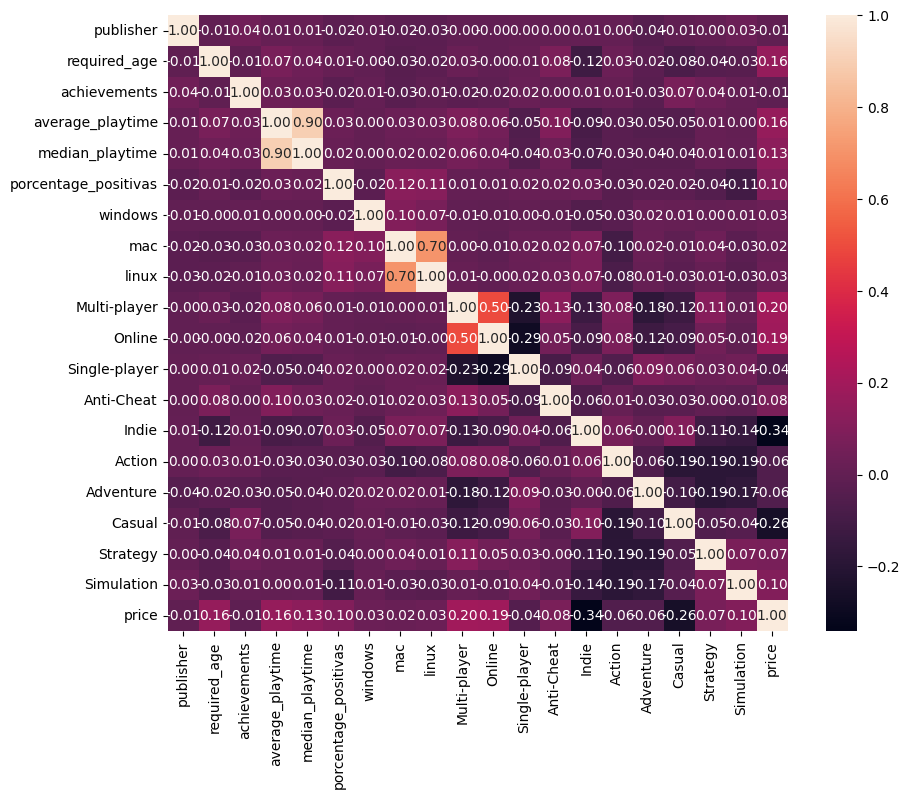

In [843]:
#vamos a hacer un pairplot y un heatmap, a ver que sale.
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, fmt=".2f");

In [844]:
#sns.pairplot(test,hue="price");

In [845]:
#al fin y al cabo, son variables de 0 y 1, es normal que me salga esto.
#Ahora, segun veo en el heatmap, casual y indie influyen bastante en el precio.
#solo mantendremos esas 2 columnas.

In [846]:
cat_df = pd.concat([cat_df,test["Indie"], test["Casual"], df["price"]],axis=1)
test = cat_df.drop(["name","english", "platforms", "categories", "genres", "steamspy_tags", "price"],axis=1)
test
#por el momento, se quedara asi,

,publisher,required_age,achievements,average_playtime,median_playtime,porcentage_positivas,windows,mac,linux,Multi-player,Online,Single-player,Anti-Cheat,Indie,Casual
0,11199,0,0,17612,317,97.39,1,1,1,1,1,0,1,0,0
1,11199,0,0,277,62,83.98,1,1,1,1,1,0,1,0,0
2,11199,0,0,187,34,89.56,1,1,1,1,0,0,1,0,0
3,11199,0,0,258,184,82.66,1,1,1,1,1,0,1,0,0
4,11199,0,0,624,415,94.80,1,1,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,9079,0,7,0,0,100.00,1,0,0,0,0,1,0,1,1
27071,1239,0,0,0,0,88.89,1,0,0,0,0,1,0,1,0
27072,3363,0,24,0,0,0.00,1,0,0,1,0,1,0,1,1
27073,503,0,0,0,0,100.00,1,1,0,0,0,1,0,1,1


In [847]:
#vamos a cojer las ultimas 5000 para testear.

test = df.tail(5000)
df = df.drop(df.tail(5000).index)
train = df.copy()

In [848]:
#vamos a probar una regresion lineal, ya tenemos nuestra X e y
def regression(train,test, target):
    train = train.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])
    obj = train[target]
    obj_test = test[target]
    test = test.drop([target],axis=1)
    train = train.drop([target],axis=1)
    model = LinearRegression()

    X = train
    y = obj

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1)
    
    model.fit(X_train,y_train)

    pred = model.predict(test)

    print(X_train.shape)
    print(y_train.shape)
    print(pred.shape)
    print(test.shape)

    print("Media Target: ", y.mean())
    print("Intercept: ",model.intercept_)
    print("Model: ", model.coef_)
    print("R2", round(r2_score(obj_test, pred),3))
    print("MAE", round(mean_absolute_error(obj_test, pred),3))
    print("MAPE", round(mean_absolute_percentage_error(obj_test, pred),3))
    print("MSE", round(mean_squared_error(obj_test, pred),3))
    print("RMSE", round(np.sqrt(mean_squared_error(obj_test, pred)),3))
    filename = 'modelo_regression_lineal'

    with open(filename, 'wb') as archivo_salida:
        pickle.dump(model, archivo_salida)

In [849]:
regression(train, test, "price")

(19466, 8)
(19466,)
(5000,)
(5000, 8)
Media Target:  6.963073919967124
Intercept:  6.270282548322789
Model:  [-1.66789465e+00  3.71592369e-01 -3.59733853e-04  6.73191246e-05
  1.77585506e-05  3.58047794e-04  5.21330952e-04  2.82472698e-02]
R2 -0.126
MAE 4.335
MAPE 2.375
MSE 31.754
RMSE 5.635


In [850]:
#cuanto es la media de precio? a ver.
train["price"].mean()

6.963073919967124

In [851]:
def guardar_csv(data,nombre):
    nombre = nombre +".csv"
    df.to_csv(f"../limpiado/{nombre}")
    


In [852]:
guardar_csv(train, "train")
guardar_csv(test, "test")


In [853]:
#PARTE NO UTILIZADA


"""action = cat_df[cat_df["genres"] == generos[0]]
adventure = cat_df[cat_df["genres"] == generos[1]]
casual = cat_df[cat_df["genres"] == generos[2]]
indie = cat_df[cat_df["genres"] == generos[3]]
violent = cat_df[cat_df["genres"] == generos[4]]
simulation = cat_df[cat_df["genres"] == generos[5]]
strategy = cat_df[cat_df["genres"] == generos[6]]
rpg = cat_df[cat_df["genres"] == generos[7]]

adventure.reset_index(inplace=True)
adventure = adventure.drop(["index"], axis=1)
casual.reset_index(inplace=True)
casual = casual.drop(["index"], axis=1)
indie.reset_index(inplace=True)
indie = indie.drop(["index"], axis=1)
violent.reset_index(inplace=True)
violent = violent.drop(["index"], axis=1)
simulation.reset_index(inplace=True)
simulation = simulation.drop(["index"], axis=1)
strategy.reset_index(inplace=True)
strategy = strategy.drop(["index"], axis=1)
rpg.reset_index(inplace=True)
rpg = rpg.drop(["index"], axis=1)"""

'action = cat_df[cat_df["genres"] == generos[0]]\nadventure = cat_df[cat_df["genres"] == generos[1]]\ncasual = cat_df[cat_df["genres"] == generos[2]]\nindie = cat_df[cat_df["genres"] == generos[3]]\nviolent = cat_df[cat_df["genres"] == generos[4]]\nsimulation = cat_df[cat_df["genres"] == generos[5]]\nstrategy = cat_df[cat_df["genres"] == generos[6]]\nrpg = cat_df[cat_df["genres"] == generos[7]]\n\nadventure.reset_index(inplace=True)\nadventure = adventure.drop(["index"], axis=1)\ncasual.reset_index(inplace=True)\ncasual = casual.drop(["index"], axis=1)\nindie.reset_index(inplace=True)\nindie = indie.drop(["index"], axis=1)\nviolent.reset_index(inplace=True)\nviolent = violent.drop(["index"], axis=1)\nsimulation.reset_index(inplace=True)\nsimulation = simulation.drop(["index"], axis=1)\nstrategy.reset_index(inplace=True)\nstrategy = strategy.drop(["index"], axis=1)\nrpg.reset_index(inplace=True)\nrpg = rpg.drop(["index"], axis=1)'